In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import minimize
import time
from IPython.display import display, clear_output

# Functions and plots

In [4]:
def f1(x1 : float, y1 : float) -> float:
    return (x1**2 + y1 - 11)**2 + (x1 + y1**2 - 7)**2

In [5]:
def f2(x2 : float, y2 : float) -> float:
    return 2*x2**2 + 1.05*x2**4 + (x2**6)/6 + x2*y2 + y2**2

In [6]:
def f1_wrapper(x : np.ndarray) -> float:
    x1, y1 = x[0], x[1]
    return f1(x1, y1)

In [7]:
def f2_wrapper(x : np.ndarray) -> float:
    x2, y2 = x[0], x[1]
    return f2(x2, y2)

In [8]:
def find_minima_in_bounds(f_wrapper : callable, x_bounds : tuple, y_bounds : tuple, number_of_points = 100) -> list:
    x = np.linspace(x_bounds[0], x_bounds[1], int(np.sqrt(number_of_points)))
    y = np.linspace(y_bounds[0], y_bounds[1], int(np.sqrt(number_of_points)))
    linespace_grid = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    mins = []
    for point in linespace_grid:
        minimum = minimize(f_wrapper, point, bounds=[x_bounds, y_bounds])
        minimum = (round(minimum.x[0], 2), round(minimum.x[1], 2), round(minimum.fun, 2))
        mins.append(minimum)
    mins = set(mins)
    mins = sorted(mins, key=lambda x: x[2])
    return mins

In [9]:
def plot_function(function : callable, wrapper : callable, x_range : tuple, y_range : tuple, title : str, num_contours=50) -> None:
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = function(X, Y)

    fig = plt.figure(figsize=(15, 6))

    # Plot 3D
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.8, antialiased=True, shade=True)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(title)
    ax1.grid(True)

    # Contours (Top view)
    ax2 = fig.add_subplot(122)
    contour = ax2.contour(X, Y, Z, num_contours, cmap='viridis')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title(title + " - Contours (Top view)")

    # find all mins
    mins = find_minima_in_bounds(wrapper, x_range, y_range)
    if mins:
        global_min = mins[0]
        ax2.plot(global_min[0], global_min[1], 'r*', markersize=10, label=f"Global min (Z = {global_min[2]})")
        local_mins = mins[1:]
        for local_min in local_mins:
            ax2.plot(local_min[0], local_min[1], 'g*', markersize=10, label=f"Local min (Z = {local_min[2]})")

    ax2.legend()

    plt.tight_layout()
    plt.show()

The function `f1(x1, y1)` is the more complicated function. It has 4 local minima, but all of them take the value Z = 0. In the evolutionary algorithm we will then strive for `any local minimum` of this function.

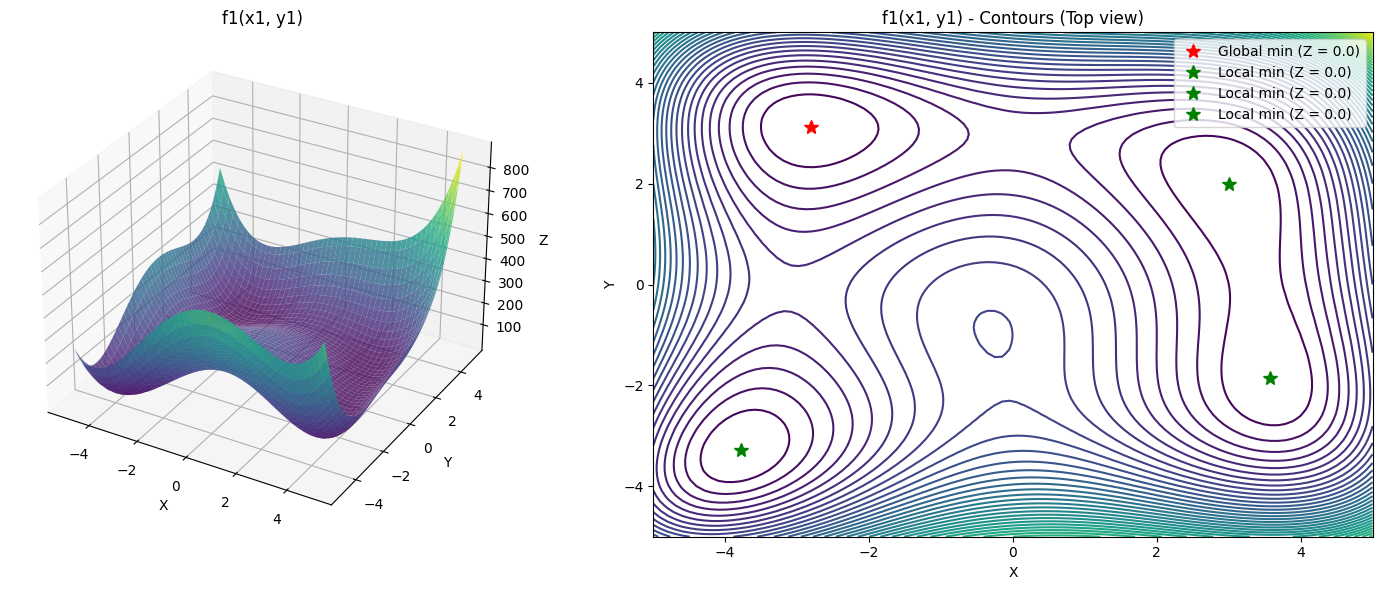

In [10]:
plot_function(f1, f1_wrapper, (-5, 5), (-5, 5), 'f1(x1, y1)')

The function `f2(x2, y2)` is a very simple three-dimensional function. It has `one global minimum` with the value Z = 0. We will strive for it when executing the evolutionary algorithm. Taking both functions into account, our fitness function should tend to a value equal to 0. This is the `smallest value` that can be achieved by the `sum of the values ​​of functions f1 and f2`.

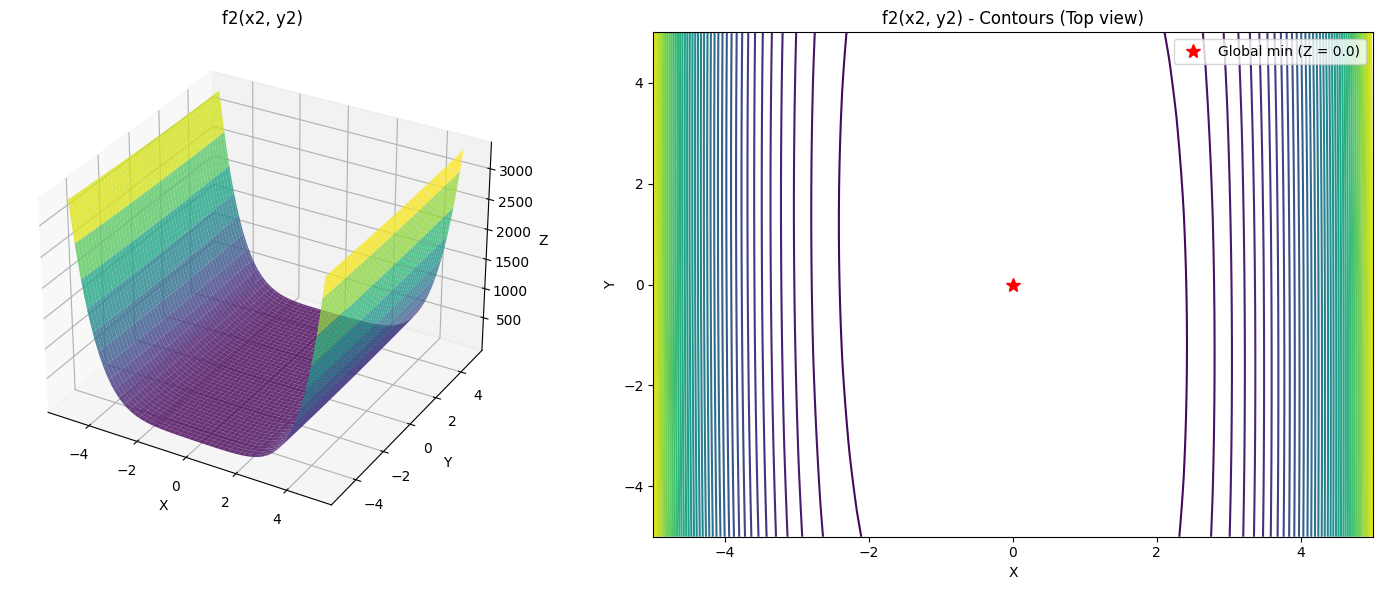

In [11]:
plot_function(f2, f2_wrapper, (-5, 5), (-5, 5), 'f2(x2, y2)')

# Implementation of evolutionary algorithm

## Evolutionary Algorithm: Entity Class

In the context of our evolutionary algorithm implementation, the `Entity` class serves as the fundamental building block. Each `Entity` represents an individual within the population, and it encapsulates essential functionalities for handling genetic information, fitness evaluations, and mutations.

Class Overview

The `Entity` class provides the following key features:

- **Chromosome Initialization**: An `Entity` can be initialized with a random chromosome or one following a normal distribution, depending on the `is_normal_dist` parameter. This chromosome encodes specific properties or parameters relevant to the problem.

- **Setting Chromosome Values**: You can set specific values for the chromosome, allowing for fine-tuning of an individual's genetic makeup.

- **Fitness Evaluation**: The `Entity` keeps track of a fitness result, which represents the suitability or performance of the individual within the evolutionary process.

- **Mutation**: Entities can undergo mutations by altering specific cells within the chromosome. This genetic variability is essential for the evolutionary algorithm to explore the solution space effectively.

- **String Representation**: The class provides a human-readable string representation that shows the chromosome and associated fitness, making it easy to monitor the population.


In [12]:
class Entity:
    def __init__(self, f_range : tuple, is_normal_dist = False) -> None:
        self.result = None
        self.chromosome = np.zeros(4)

        if is_normal_dist:
            self.initialize_normal_dist_chromosome(f_range)
        else:
            self.initialize_random_chromosome(f_range)

    def get_chromosome(self) -> np.ndarray:
        return self.chromosome

    def get_result(self) -> float:
        return self.result

    def initialize_random_chromosome(self, f_range : tuple) -> None:
        self.chromosome[0] = np.random.uniform(f_range[0], f_range[1])
        self.chromosome[1] = np.random.uniform(f_range[0], f_range[1])
        self.chromosome[2] = np.random.uniform(f_range[0], f_range[1])
        self.chromosome[3] = np.random.uniform(f_range[0], f_range[1])

    def initialize_normal_dist_chromosome(self, f_range : tuple) -> None:
        x_mean, y_mean = -0.3, -0.9
        x_stddev, y_stddev = 0.1, 0.1
        self.chromosome[0] = np.random.normal(x_mean, x_stddev)
        self.chromosome[1] = np.random.normal(y_mean, y_stddev)
        self.chromosome[2] = np.random.normal(f_range[0], f_range[1])
        self.chromosome[3] = np.random.normal(f_range[0], f_range[1])

    def set_chromosome_values(self, x1 : float, y1 : float, x2 : float, y2 : float) -> None:
        self.chromosome[0] = x1
        self.chromosome[1] = y1
        self.chromosome[2] = x2
        self.chromosome[3] = y2

    def set_result(self, result : float) -> None:
        self.result = result

    def mutate_cell(self, index : int, mutation : float) -> None:
        self.chromosome[index] += mutation

    def __str__(self) -> str:
        return f"Entity: {self.chromosome}, Fitness: {self.result}"

## Evolutionary Algorithm: Population Class

The `Population` class is a fundamental component of our evolutionary algorithm. It manages a population of `Entity` objects and is responsible for initializing, evaluating, and selecting individuals within the population.

Class Overview

The `Population` class offers the following key functionalities:

- **Initialization**: Upon creation of a `Population` object, you specify the initial population size and a range for initializing chromosome values. Additionally, you can choose whether to use a normal distribution for initialization.

- **Population Initialization**: The class initializes the population by creating a set of `Entity` objects with the specified characteristics. These entities form the initial generation.

- **Population Evaluation**: You can evaluate the fitness of each entity in the population by calling the `evaluate_population` method. This evaluation is based on a fitness function, and an optional penalty can be applied.

- **Best Entity Identification**: The class identifies the best-performing entity in the population. The best entity is determined based on their fitness scores.

- **String Representation**: The `Population` class provides a string representation, allowing you to view information about the entities in the population.

The `Population` class serves as the container for a group of `Entity` objects and manages their evolution within the context of the evolutionary algorithm. It plays a critical role in the selection, crossover, and mutation phases of the algorithm.


In [13]:
class Population:
    def __init__(self, f_range : tuple, population_size : int, is_normal_dist : bool) -> None:
        self.population_size = population_size
        self.entities = []
        self.best_entity = None
        self.function_range = f_range
        self.initialize_population(is_normal_dist)

    def initialize_population(self, is_normal_dist) -> None:
        for _ in range(self.population_size):
            self.entities.append(Entity(self.function_range, is_normal_dist))

    def evaluate_population(self, penalty : int) -> None:
        for entity in self.entities:
            entity.set_result(fitness_function(entity, self.function_range, penalty))
        self.entities = sorted(self.entities, key=lambda entity: entity.result)

    def find_best_entity(self) -> None:
        self.best_entity = min(self.entities, key=lambda entity: entity.result)

    def __str__(self) -> str:
        result = ""
        for entity in self.entities:
            result += str(entity) + "\n"
        return result

## Evolutionary Algorithm: Fitness Function

The `fitness_function` is a critical component of our evolutionary algorithm. It calculates the fitness or suitability of an `Entity` based on its chromosome values. The function combines two individual fitness components, f1 and f2, and applies a penalty for chromosome values that fall outside a specified range.

Function Overview

The `fitness_function` offers the following key functionalities:

- **Parameter**: The function takes an `Entity` object, a range for chromosome values (`f_range`), and a penalty value as input parameters.

- **Chromosome Values**: The chromosome of the provided `Entity` contains four values, denoting x1, y1, x2, and y2.

- **Fitness Components**: The function calculates the fitness as the sum of two fitness components, f1(x1, y1) and f2(x2, y2), representing the performance of an entity in two different aspects of the problem.

- **Penalty for Out-of-Bounds Values**: If any of the chromosome values fall outside the specified range (`f_range`), the function applies a penalty to the fitness score for each out-of-bounds value proportional to the degree of crossing the barrier.

- **Final Fitness Score**: The overall fitness score is the sum of the two fitness components, adjusted for any penalties due to out-of-bounds values.

The `fitness_function` is a critical element of the evolutionary algorithm, as it determines the suitability of individuals within the population based on their genetic makeup. The penalties for out-of-bounds values help guide the evolution towards solutions within the specified range.


In [14]:
def fitness_function(entity: Entity, f_range: tuple, penalty: float) -> float:
    x1, y1, x2, y2 = entity.get_chromosome()
    result = f1(x1, y1) + f2(x2, y2)
    penalty_total = 0

    if x1 < f_range[0] or x1 > f_range[1]:
        penalty_total += abs(x1 - (f_range[0] + f_range[1]) / 2) * penalty
    if y1 < f_range[0] or y1 > f_range[1]:
        penalty_total += abs(y1 - (f_range[0] + f_range[1]) / 2) * penalty
    if x2 < f_range[0] or x2 > f_range[1]:
        penalty_total += abs(x2 - (f_range[0] + f_range[1]) / 2) * penalty
    if y2 < f_range[0] or y2 > f_range[1]:
        penalty_total += abs(y2 - (f_range[0] + f_range[1]) / 2) * penalty

    result += penalty_total
    return result

## Evolutionary Algorithm: EvolutionaryAlgorithm Class

The `EvolutionaryAlgorithm` class represents the core of our evolutionary algorithm implementation. It orchestrates the evolution process by managing a population of `Entity` objects, applying selection, mutation, and crossover operations to guide the population towards optimal solutions.

 Class Overview

The `EvolutionaryAlgorithm` class offers the following key functionalities:

- **Initialization**: Upon creation of an `EvolutionaryAlgorithm` object, you provide several essential parameters, including the fitness function, the population, the maximum runtime (`max_time`), penalties, mutation rate, mutation range, and crossover rate.

- **Tournament Selection**: The class implements tournament selection, where individuals within the population compete pairwise. The entity with the better fitness survives for the next generation.

- **Gaussian Mutation**: Genetic diversity is introduced through Gaussian mutation. This process allows for small random changes in the chromosome values of individuals.

- **Crossover**: The crossover operation creates new individuals by combining the genetic material of two parent entities. The crossover rate determines the likelihood of this operation.

- **Running the Algorithm**: The `run_algorithm` method executes the evolutionary algorithm. It repeatedly applies selection, mutation, and crossover, evaluates the fitness of the population, and tracks the best-performing entity.

- **Visualization (Optional)**: The algorithm can be visualized by providing the `visualize` parameter, which allows you to monitor its progress.

- **Best Entity Tracking**: Throughout the algorithm's runtime, the best-performing entity is continually tracked, ensuring that you can retrieve the best solution found.

The `EvolutionaryAlgorithm` class serves as the core engine for your evolutionary algorithm, providing the logic for evolving a population of entities towards optimal solutions.


In [15]:
class EvolutionaryAlgorithm:
    def __init__(self,
                 fitness_function : callable,
                 population : Population,
                 max_time : int,
                 penalty : int,
                 mutation_rate : float,
                 mutation_range : float,
                 crossover_rate : float):

        self.fitness_function = fitness_function
        self.population = population
        self.max_time = max(max_time, 0)
        self.start_time = self.max_time
        self.penalty = penalty
        self.mutation_rate = mutation_rate
        self.mutation_range = mutation_range
        self.crossover_rate = crossover_rate
        self.best_entity = None

    def tournament_selection(self):
        new_generation = []
        for entity in self.population.entities:
            opponent = np.random.choice(self.population.entities)
            if entity.get_result() < opponent.get_result():
                new_generation.append(entity)
            else:
                new_generation.append(opponent)
        self.population.entities = new_generation

    def gaussian_mutation(self):
        for entity in self.population.entities:
            for i in range(len(entity.get_chromosome())):
                if np.random.uniform(0, 1) < self.mutation_rate:
                    entity.mutate_cell(i, np.random.normal(0, self.mutation_range))

    def crossover(self):
        new_generation = []
        for entity in self.population.entities:
            if np.random.uniform(0, 1) < self.crossover_rate:
                partner = np.random.choice(self.population.entities)
                crossover_point = np.random.randint(0, len(entity.get_chromosome()))
                child = Entity(self.population.function_range)
                child_chromosome = list(entity.get_chromosome())[:crossover_point] + list(partner.get_chromosome())[crossover_point:]
                child.set_chromosome_values(*child_chromosome)
                new_generation.append(child)
            else:
                new_generation.append(entity)
        self.population.entities = new_generation


    def run_algorithm(self, visualize = False):
        self.population.evaluate_population(self.penalty)
        self.population.find_best_entity()
        self.best_entity = self.population.best_entity
        while self.max_time > 0:
            self.tournament_selection()
            self.gaussian_mutation()
            self.crossover()
            self.population.evaluate_population(self.penalty)
            self.population.find_best_entity()
            if self.population.best_entity.get_result() < self.best_entity.get_result():
                self.best_entity = self.population.best_entity
            self.max_time -= 1
            if visualize:
                visualize_algorithm(self.population, self.max_time, self.start_time)
        return self.best_entity

# Algorithm visulaization

In [16]:
def get_graph_background():
    # Tworzenie siatki danych
    x = np.linspace(-9, 9, 100)
    y = np.linspace(-9, 9, 100)
    X, Y = np.meshgrid(x, y)

    # Obliczanie wartości funkcji f1 i f2 na danej siatce
    Z1 = f1(X, Y)
    Z2 = f2(X, Y)

    # Tworzenie nowego wykresu
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

    # Wykres f1(x, y) - z kolorami
    contour1 = ax1.contour(X, Y, Z1, 60, cmap='viridis')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title('f1(x, y) - Colored Contours (Top view)')

    # Wykres f2(x, y) - z kolorami
    contour2 = ax2.contour(X, Y, Z2, 60, cmap='viridis')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('f2(x, y) - Colored Contours (Top view)')

    # Dodawanie punktów minimalnych do obu wykresów
    mins1 = find_minima_in_bounds(f1_wrapper, (-5, 5), (-5, 5))
    if mins1:
        global_min1 = mins1[0]
        ax1.plot(global_min1[0], global_min1[1], 'r*', markersize=10, label=f"Global min (Z = {global_min1[2]})")
        local_mins1 = mins1[1:]
        for local_min1 in local_mins1:
            ax1.plot(local_min1[0], local_min1[1], 'g*', markersize=10, label=f"Local min (Z = {local_min1[2]}")

    mins2 = find_minima_in_bounds(f2_wrapper, (-5, 5), (-5, 5))
    if mins2:
        global_min2 = mins2[0]
        ax2.plot(global_min2[0], global_min2[1], 'r*', markersize=10, label=f"Global min (Z = {global_min2[2]})")
        local_mins2 = mins2[1:]
        for local_min2 in local_mins2:
            ax2.plot(local_min2[0], local_min2[1], 'g*', markersize=10, label=f"Local min (Z = {local_min2[2]}")

    # Legenda na obu wykresach
    ax1.legend()
    ax2.legend()

    plt.tight_layout()
    return (plt, ax1, ax2)


In [17]:
def visualize_algorithm(population, current_time, max_time):
    sleep_time = 0.01
    my_plt, ax1, ax2 = get_graph_background()
    x1 = [entity.get_chromosome()[0] for entity in population.entities]
    y1 = [entity.get_chromosome()[1] for entity in population.entities]
    x2 = [entity.get_chromosome()[2] for entity in population.entities]
    y2 = [entity.get_chromosome()[3] for entity in population.entities]
    generation_number = max_time - current_time

    # Wykres f1(x, y) - z kolorami
    ax1.scatter(x1, y1, marker='o', s=30, c='b', label=f'Generation {generation_number}')

    # Wykres f2(x, y) - z kolorami
    ax2.scatter(x2, y2, marker='o', s=30, c='b', label=f'Generation {generation_number}')

    ax1.legend()
    ax2.legend()

    display(my_plt.gcf())
    time.sleep(sleep_time)
    clear_output(wait=True)
    my_plt.close()


## My observations of the hyperparameters - performance 

`Pretty good` parameters:

- max time: +/- 300
- penalty: +/- 10000
- mutation_rate: +/- 0.05
- mutation_range: +/- 0.5
- crossover_rate: +/- 0.85
- population_size: +/- 40
- is_normal_dist: False

Other:

- After finding the minimum, the algorithm rather remains there until the end of the simulation. 
- Random placement provides greater variety in the selection of the minimum of function f1
- Greater mutation range and rate provide greater variety in the selection of the minimum of function f1


Fitness function values from 100 runs of the algorithm with above hyperparameters:
- Average score: 0.00013094202125676257
- Best score: 1.7322514921779991e-07
- Standard deviation: 0.00019573752185878419

In [18]:
visualize = False
is_normal_dist = False
max_time = 300
penalty = 10000
mutation_rate = 0.05
mutation_range = 0.5
crossover_rate = 0.85
population_size = 40
start_population = Population((-5, 5), population_size, is_normal_dist)

# algorthm = EvolutionaryAlgorithm(fitness_function, start_population, max_time, penalty, mutation_rate, mutation_range, crossover_rate)
# best_entity = algorthm.run_algorithm(visualize)

# print("Best Entity:")
# print(best_entity)
# print("Final population:")
# print(algorthm.population)

# best_fitneses = []
# for _ in range(100):
#     algorthm = EvolutionaryAlgorithm(fitness_function, start_population, max_time, penalty, mutation_rate, mutation_range, crossover_rate)
#     best_entity = algorthm.run_algorithm(visualize)
#     best_fitneses.append(best_entity.get_result())
# average = sum(best_fitneses) / len(best_fitneses)
# best_score = min(best_fitneses)
# std_deviation = np.std(np.array(best_fitneses))

# print(f"Average score: {average}")
# print(f"Best score: {best_score}")
# print(f"Standard deviation: {std_deviation}")

# Performance graphs

In [19]:
def run_algorithm_with_distribution(is_normal_dist, hyperparameters, key, value):
        hyperparameters[key] = value
        start_population = Population((-5, 5), hyperparameters['population_size'], is_normal_dist)
        algorithm = EvolutionaryAlgorithm(fitness_function,
                                          start_population,
                                          hyperparameters['max_time'],
                                          hyperparameters['penalty'],
                                          hyperparameters['mutation_rate'],
                                          hyperparameters['mutation_range'],
                                          hyperparameters['crossover_rate'])
        best_entity = algorithm.run_algorithm()
        return best_entity.get_result()

In [22]:
def draw_performance_graphs():
    optimal_max_time = 300
    optimal_penalty = 10000
    optimal_mutation_rate = 0.05
    optimal_mutation_range = 0.5
    optimal_crossover_rate = 0.85
    optimal_population_size = 40

    hyperparameters = {
        'max_time': optimal_max_time,
        'penalty': optimal_penalty,
        'mutation_rate': optimal_mutation_rate,
        'mutation_range': optimal_mutation_range,
        'crossover_rate': optimal_crossover_rate,
        'population_size': optimal_population_size
    }

    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.ravel()

    # Max time performance graph
    x1 = np.linspace(10, 300, 20)
    y1_normal = [run_algorithm_with_distribution(True, hyperparameters, 'max_time', x) for x in x1]
    y1_random = [run_algorithm_with_distribution(False, hyperparameters, 'max_time', x) for x in x1]
    hyperparameters['max_time'] = optimal_max_time

    axs[0].plot(x1, y1_normal, label='Normal Distribution', color='blue')
    axs[0].plot(x1, y1_random, label='Random Distribution', color='orange')
    axs[0].set_xlabel('Max time')
    axs[0].set_ylabel('Fitness')
    axs[0].set_title('Max time performance graph')
    axs[0].legend()

    # Penalty performance graph
    x2 = np.linspace(100, 10000, 20)
    y2_normal = [run_algorithm_with_distribution(True, hyperparameters, 'penalty', x) for x in x2]
    y2_random = [run_algorithm_with_distribution(False, hyperparameters, 'penalty', x) for x in x2]
    hyperparameters['penalty'] = optimal_penalty

    axs[1].plot(x2, y2_normal, label='Normal Distribution', color='blue')
    axs[1].plot(x2, y2_random, label='Random Distribution', color='orange')
    axs[1].set_xlabel('Penalty')
    axs[1].set_ylabel('Fitness')
    axs[1].set_title('Penalty performance graph')
    axs[1].legend()

    # Mutation rate performance graph
    x3 = np.linspace(0.01, 0.99, 20)
    y3_normal = [run_algorithm_with_distribution(True, hyperparameters, 'mutation_rate', x) for x in x3]
    y3_random = [run_algorithm_with_distribution(False, hyperparameters, 'mutation_rate', x) for x in x3]
    hyperparameters['mutation_rate'] = optimal_mutation_rate

    axs[2].plot(x3, y3_normal, label='Normal Distribution', color='blue')
    axs[2].plot(x3, y3_random, label='Random Distribution', color='orange')
    axs[2].set_xlabel('Mutation rate')
    axs[2].set_ylabel('Fitness')
    axs[2].set_title('Mutation rate performance graph')
    axs[2].legend()

    # Mutation range performance graph
    x4 = np.linspace(0.1, 5, 20)
    y4_normal = [run_algorithm_with_distribution(True, hyperparameters, 'mutation_range', x) for x in x4]
    y4_random = [run_algorithm_with_distribution(False, hyperparameters, 'mutation_range', x) for x in x4]
    hyperparameters['mutation_range'] = optimal_mutation_range

    axs[3].plot(x4, y4_normal, label='Normal Distribution', color='blue')
    axs[3].plot(x4, y4_random, label='Random Distribution', color='orange')
    axs[3].set_xlabel('Mutation range')
    axs[3].set_ylabel('Fitness')
    axs[3].set_title('Mutation range performance graph')
    axs[3].legend()

    # Crossover rate performance graph
    x5 = np.linspace(0.05, 0.95, 20)
    y5_normal = [run_algorithm_with_distribution(True, hyperparameters, 'crossover_rate', x) for x in x5]
    y5_random = [run_algorithm_with_distribution(False, hyperparameters, 'crossover_rate', x) for x in x5]
    hyperparameters['crossover_rate'] = optimal_crossover_rate

    axs[4].plot(x5, y5_normal, label='Normal Distribution', color='blue')
    axs[4].plot(x5, y5_random, label='Random Distribution', color='orange')
    axs[4].set_xlabel('Crossover rate')
    axs[4].set_ylabel('Fitness')
    axs[4].set_title('Crossover rate performance graph')
    axs[4].legend()

    # Population size performance graph
    x6 = np.linspace(5, 50, 20)
    x6 = x6.astype(int)
    y6_normal = [run_algorithm_with_distribution(True, hyperparameters, 'population_size', x) for x in x6]
    y6_random = [run_algorithm_with_distribution(False, hyperparameters, 'population_size', x) for x in x6]
    hyperparameters['population_size'] = optimal_population_size

    axs[5].plot(x6, y6_normal, label='Normal Distribution', color='blue')
    axs[5].plot(x6, y6_random, label='Random Distribution', color='orange')
    axs[5].set_xlabel('Population size')
    axs[5].set_ylabel('Fitness')
    axs[5].set_title('Population size performance graph')
    axs[5].legend()

    plt.tight_layout()
    plt.show()

## Conclusions from Evolutionary Algorithm Performance Analysis

In my exploration of the Evolutionary Algorithm's performance, several key insights have emerged from the generated graphs. These findings shed light on the behavior of the algorithm under varying parameter settings and offer valuable guidance for optimizing its performance. Those grapghs are generated for only one run of the algorithm for each parametrize hyperparameter so it can vary from run to run.

**1. Max Time Performance**
- The algorithm's performance improves as the maximum execution time is increased. It `stabilizes after approximately 100 iterations`, indicating that allocating more time won't lead to better results. 

**2. Penalty Performance**
- `The penalty value appears to have little impact on the algorithm's efficiency`.

**3. Mutation Rate Performance**
- `Mutation rates between 1% and 20% are most effective`. High mutation probabilities can introduce instability, suggesting that a balanced approach to mutations is preferable.

**4. Mutation Range Performance**
- `A mutation range of about 0.5 to 1` (occupying roughly 1/50-1/25 of the function's domain) produces optimal results. Values close to 0 impair the algorithm's ability to discover the optimal solution.

**5. Crossover Rate Performance**
- `A high crossover rate is crucial for the algorithm's success`. It significantly influences the quality of results, emphasizing the importance of crossover in the algorithm's search process.

**6. Population Size Performance**
- A population size of at least 10 individuals is necessary to derive meaningful results. `The peak performance is achieved with a population size of around 40 individuals`, aligning with the optimal configuration. It is hard to see on the graph because of the scale. For small population the results are very bad. However between 10 and 40 there is also a huge difference in performance when I was testing the algorithm on my own.

**7. Normal vs Random starting distribution performance**
Starting distribution has little impact overall on the algorithm's performance when it comes to finding the minimum solution. All of the above comments more or less apply to both initial distributions.

These conclusions offer valuable insights into the algorithm's behavior. However, it's important to emphasize that these observations serve as guidelines rather than strict rules. Fine-tuning the algorithm for specific problem domains may require further experimentation and adaptation. Generating graphs for these parameters takes about 3 minutes when I consider only one call to the algorithm for each new variable value. If I wanted to make graphs for the average of 100 values, it would take about 300 times longer, so below I selected two parameters that I tested in the above-mentioned way.


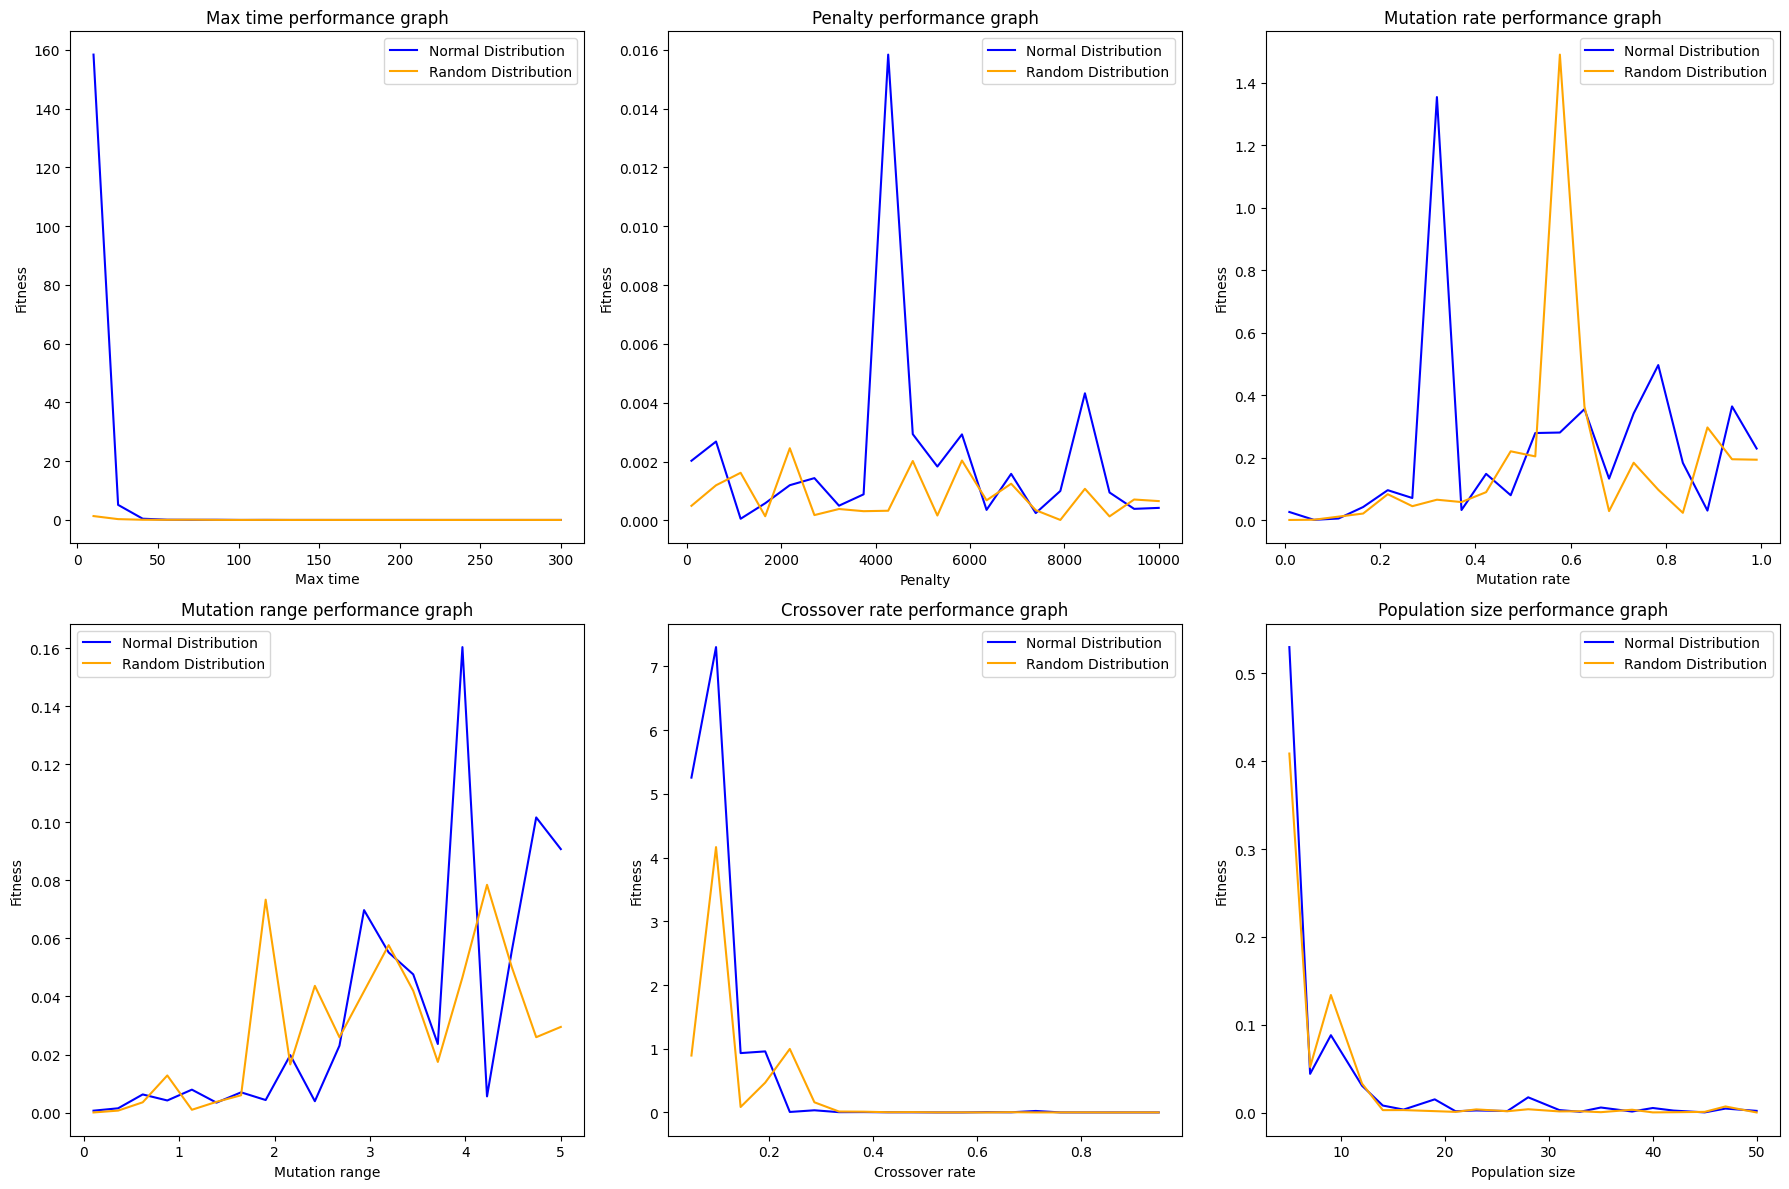

In [23]:
draw_performance_graphs()

## Detailed analysis of two selected hyperparameters

In [28]:
def draw_detailed_graphs():
    number_of_iterations = 20
    optimal_max_time = 200
    optimal_penalty = 3000
    optimal_mutation_rate = 0.03
    optimal_mutation_range = 0.3
    optimal_crossover_rate = 0.95
    optimal_population_size = 30

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

    fig.suptitle('Number of algorithm iterations per parameter: ' + str(number_of_iterations))

    # Crossover rate performance graph
    x1 = np.linspace(0.05, 0.99, 30)
    y1_normal = []
    y1_random = []

    for crossover_rate in x1:
        results_normal = []
        results_random = []
        for _ in range(number_of_iterations):
            start_population_normal = Population((-5, 5), optimal_population_size, True)
            start_population_random = Population((-5, 5), optimal_population_size, False)

            algorithm_normal = EvolutionaryAlgorithm(fitness_function, start_population_normal, optimal_max_time, optimal_penalty, optimal_mutation_rate, optimal_mutation_range, crossover_rate)
            algorithm_random = EvolutionaryAlgorithm(fitness_function, start_population_random, optimal_max_time, optimal_penalty, optimal_mutation_rate, optimal_mutation_range, crossover_rate)

            best_entity_normal = algorithm_normal.run_algorithm()
            best_entity_random = algorithm_random.run_algorithm()

            results_normal.append(best_entity_normal.get_result())
            results_random.append(best_entity_random.get_result())

        y1_normal.append(sum(results_normal) / len(results_normal))
        y1_random.append(sum(results_random) / len(results_random))

    ax1.plot(x1, y1_normal, label='Normal Distribution', color='blue')
    ax1.plot(x1, y1_random, label='Random Distribution', color='orange')
    ax1.set_xlabel('Crossover rate')
    ax1.set_ylabel('Fitness')
    ax1.set_title('Crossover rate performance graph')
    ax1.legend()  # Dodanie legendy

    # Mutation rate performance graph
    x2 = np.linspace(0.05, 0.99, 30)
    y2_normal = []
    y2_random = []

    for mutation_rate in x2:
        results_normal = []
        results_random = []
        for _ in range(number_of_iterations):
            start_population_normal = Population((-5, 5), optimal_population_size, True)
            start_population_random = Population((-5, 5), optimal_population_size, False)

            algorithm_normal = EvolutionaryAlgorithm(fitness_function, start_population_normal, optimal_max_time, optimal_penalty, mutation_rate, optimal_mutation_range, optimal_crossover_rate)
            algorithm_random = EvolutionaryAlgorithm(fitness_function, start_population_random, optimal_max_time, optimal_penalty, mutation_rate, optimal_mutation_range, optimal_crossover_rate)

            best_entity_normal = algorithm_normal.run_algorithm()
            best_entity_random = algorithm_random.run_algorithm()

            results_normal.append(best_entity_normal.get_result())
            results_random.append(best_entity_random.get_result())

        y2_normal.append(sum(results_normal) / len(results_normal))
        y2_random.append(sum(results_random) / len(results_random))

    ax2.plot(x2, y2_normal, label='Normal Distribution', color='blue')
    ax2.plot(x2, y2_random, label='Random Distribution', color='orange')
    ax2.set_xlabel('Mutation rate')
    ax2.set_ylabel('Fitness')
    ax2.set_title('Mutation rate performance graph')
    ax2.legend()  # Dodanie legendy

    plt.tight_layout()
    plt.show()


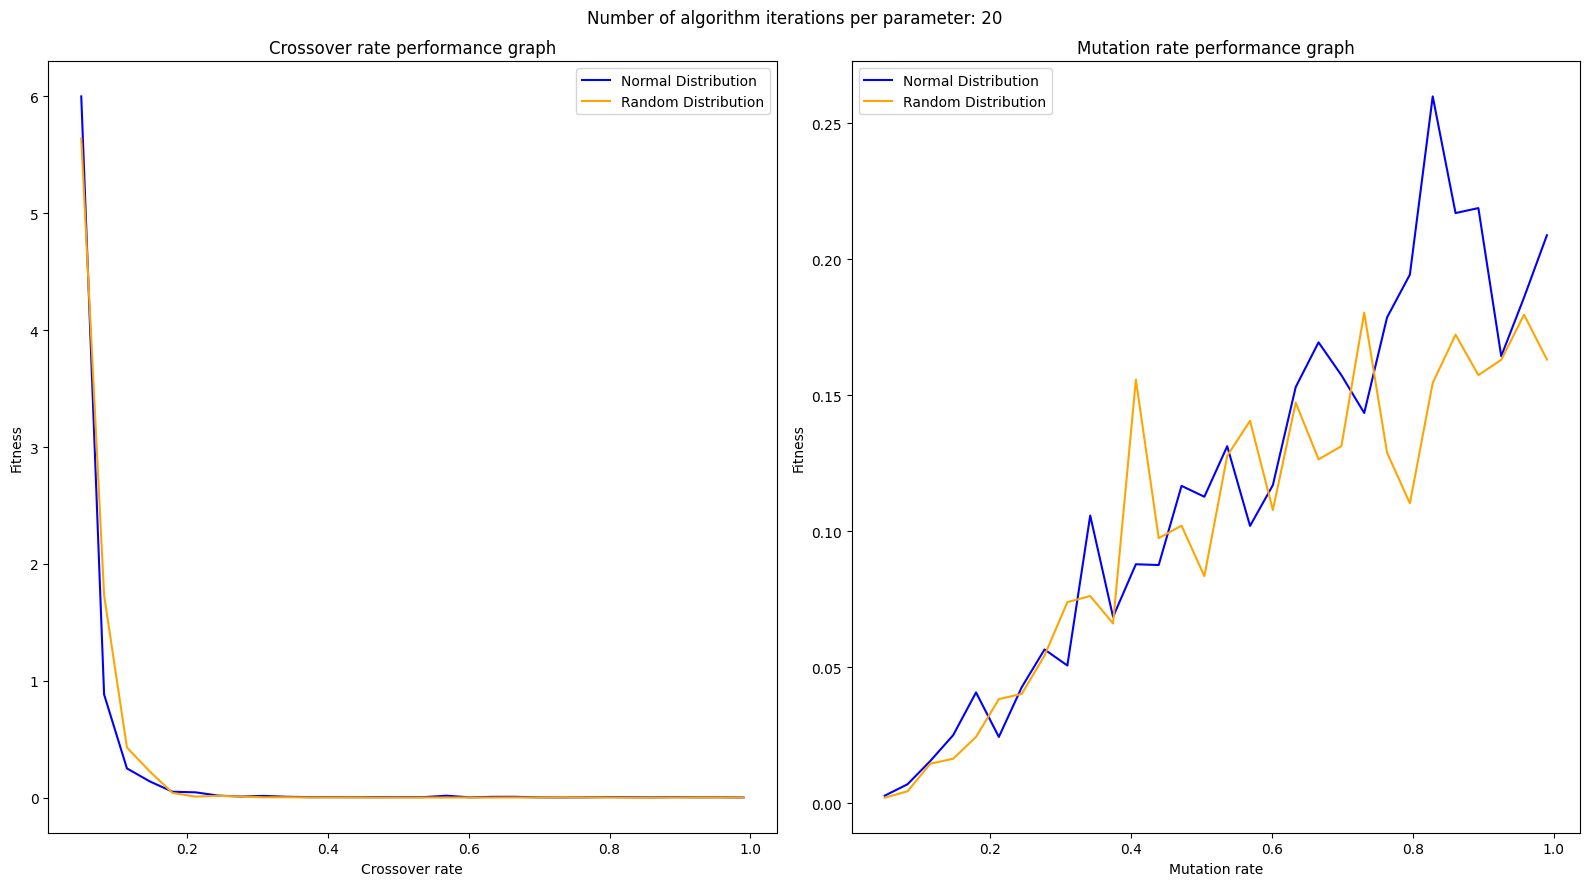

In [29]:
draw_detailed_graphs()

# Tests

In [19]:
import ipytest
import pytest
ipytest.autoconfig()

In [20]:
@pytest.fixture
def mock_np_random_uniform(monkeypatch):

    def mock_uniform(low, high):
        return 0.5

    monkeypatch.setattr(np.random, 'uniform', mock_uniform)

def test_initialize_random_chromosome(mock_np_random_uniform):
    f_range = (0, 1)
    entity = Entity(f_range)
    assert entity.chromosome[0] == 0.5
    assert entity.chromosome[1] == 0.5
    assert entity.chromosome[2] == 0.5
    assert entity.chromosome[3] == 0.5

def test_set_chromosome_values():
    entity = Entity((0, 1))
    entity.set_chromosome_values(1.0, 2.0, 3.0, 4.0)
    assert entity.chromosome[0] == 1.0
    assert entity.chromosome[1] == 2.0
    assert entity.chromosome[2] == 3.0
    assert entity.chromosome[3] == 4.0

def test_str_representation():
    entity = Entity((0, 1))
    entity.set_chromosome_values(1.0, 2.0, 3.0, 4.0)
    entity.result = 42.0
    assert str(entity) == "Entity: [1. 2. 3. 4.], Fitness: 42.0"

def test_fitness_function():
    entity = Entity((0, 1))
    entity.set_chromosome_values(0.5, 0.5, 0.7, 0.7)
    f_range = (0, 1)
    penalty = 10.0
    expected_result = f1(0.5, 0.5) + f2(0.7, 0.7)
    result = fitness_function(entity, f_range, penalty)
    assert result == expected_result

def test_fitness_function_penalty():
    entity = Entity((0, 1))
    entity.set_chromosome_values(1.5, 0.5, 0.7, 0.7)
    f_range = (0, 1)
    penalty = 10.0
    expected_result = f1(1.5, 0.5) + f2(0.7, 0.7) + penalty
    result = fitness_function(entity, f_range, penalty)
    assert result == expected_result

def test_initialize_population(mock_np_random_uniform):
    f_range = (0, 1)
    population_size = 10
    population = Population(f_range, population_size, False)
    assert len(population.entities) == population_size

def test_evaluate_population(mock_np_random_uniform):
    f_range = (0, 1)
    population_size = 5
    population = Population(f_range, population_size, False)
    penalty = 10.0
    population.evaluate_population(penalty)
    for entity in population.entities:
        assert entity.result is not None

def test_find_best_entity(mock_np_random_uniform):
    f_range = (0, 1)
    population_size = 5
    population = Population(f_range, population_size, False)
    penalty = 10.0
    population.evaluate_population(penalty)
    population.find_best_entity()
    assert population.best_entity == min(population.entities, key=lambda entity: entity.result)

ipytest.run()

........                                                                                     [100%]
8 passed in 0.03s


<ExitCode.OK: 0>